Paper:  https://www.mdpi.com/1099-4300/26/4/313  
cdoe from Gabriele Cenedese 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import qiskit.quantum_info as qi

from qiskit import(QuantumCircuit, QuantumRegister, ClassicalRegister, transpile)
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_provider import IBMProvider
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import Sampler
from qiskit_ibm_runtime import Options, Session

plt.style.use('default')
plt.rcParams.update({"text.usetex":True,"font.family":"serif","font.serif":["Palatino"] })

In [ ]:

IBMProvider.save_account('token',overwrite=True)
#provider = IBMProvider()

# Select a different hub/group/project.
provider = IBMProvider(instance="ibm-q-cern/infn/qcqcd1")

In [3]:
print(provider.backends(min_num_qubits=5, simulator=False, operational=True))

[<IBMBackend('ibm_nazca')>, <IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_cairo')>, <IBMBackend('ibm_torino')>]


In [4]:

device = provider.get_backend("ibm_cairo")
noise_model = NoiseModel.from_backend(device)
coupling_map = device.configuration().coupling_map

In [5]:
sim_ideal = AerSimulator()
sim_real =  AerSimulator.from_backend(device)

In [ ]:
def hammingDistance(n1, n2) :
    #Calculate the XOR of two numbers:
    x = n1 ^ n2
    setBits = 0
    #Count the number of set bits (=1): 
    while (x > 0) :
        setBits += x & 1
        x >>= 1
    return setBits

def randomMeasEntropy(p,Nqubit,Nmeas):
    Xm=np.zeros([Nmeas])
    for j in range(Nmeas): 
        X=0
        for m in range(2**Nqubit):
            for n in range(2**Nqubit):
                H=hammingDistance(m, n)
                X = X + ((-2)**(-H))*p[m,j]*p[n,j]
                        
        X=X*(2**Nqubit)
        Xm[j]=X

    
    return -np.log2(np.mean(Xm))  

def randomMeas(circuit,Nqubit):
    # Number of qubits and classical bits for the measurement
    for i in range(Nqubit):
        circuit.append(qi.random_unitary(2,seed=None),[i])
    circuit.measure(range(Nqubit),range(Nqubit))
    return circuit

def randomMeasAll(circuit,Nqubit):
    # Number of qubits and classical bits for the measurement
    for i in range(Nqubit+1):
        circuit.append(qi.random_unitary(2,seed=None),[i])
    circuit.measure(range(Nqubit+1),range(Nqubit+1))
    return circuit

# QFT Shakeel

In [ ]:
def quantumWalkQFT_shakeel(Nqubit,timeStep,CoinInit, CoinToss,measureAll=True):
    iqft = QFT(num_qubits=Nqubit, approximation_degree=0, do_swaps=False, inverse=True).to_gate()
    qft  = QFT(num_qubits=Nqubit, approximation_degree=0, do_swaps=False, inverse=False).to_gate()
    qr = QuantumRegister(Nqubit, 'q')
    anc = QuantumRegister(1, 'coin')
    if measureAll==True:
        cr = ClassicalRegister(Nqubit+1, 'c')
    else:
        cr = ClassicalRegister(Nqubit, 'c')

    circuit = QuantumCircuit(qr, anc, cr,name="quantum walk QFT shakeel")
    circuit.append(CoinInit,[Nqubit])

    for i in range(timeStep):
        circuit.append(CoinToss,[Nqubit])
        
        #CNOT ctrl(coin) and targ(walker)
        for j in range(Nqubit):
            circuit.cnot(Nqubit,Nqubit-j-1)

        #QFT (no swaps)
        circuit.append(qft, range(Nqubit))

        #Phase-gates on walker's register (\tilde{Omega})
        for j in range(Nqubit):    
            circuit.p(-2 * np.pi / 2**(j+1), j)
        
        #IQFT (no swaps)
        circuit.append(iqft, range(Nqubit))
        
        #CNOT ctrl(coin) and targ(walker)
        for j in range(Nqubit):
            circuit.cnot(Nqubit,j)
    
    return circuit

In [ ]:
CoinInit=QuantumCircuit(1,name='Coin Initial')
CoinInit.u(np.pi/6,np.pi/2,0,[0])

CoinToss=QuantumCircuit(1,name='Coin Toss')
CoinToss.u(np.pi/2,2*np.pi,np.pi,[0]) # hadamard coin

In [ ]:
quantumWalkQFT_shakeel(2,1,CoinInit,CoinToss,measureAll=False).draw('mpl')

# Efficient QFT

## Simulations

In [221]:
def sigmaGateQFT(Nqubit):
    sigma=QuantumCircuit(Nqubit+1,name='sigmaGateQFT')
    for i in range(Nqubit):
        sigma.p(-2*np.pi / 2**(i+1),i)
    for i in range(Nqubit):
        if i==0:
            pass   
        else:
            sigma.cp(2*np.pi / 2**(i),Nqubit,i)
    return sigma


def quantumWalkQFT(Nqubit,timeStep,CoinInit, CoinToss,measureAll=True):
    qr = QuantumRegister(Nqubit, 'q')
    anc = QuantumRegister(1, 'coin')
    if measureAll==True:
        cr = ClassicalRegister(Nqubit+1, 'c')
    else:
        cr = ClassicalRegister(Nqubit, 'c')

    circuit = QuantumCircuit(qr, anc, cr,name="quantum walk QFT")
    for i in range(Nqubit):
        circuit.h(i)
    circuit.append(CoinInit,[Nqubit])

    for i in range(timeStep):
        circuit.append(CoinToss,[Nqubit])
        circuit.append(sigmaGateQFT(Nqubit),range(Nqubit+1))
    
    circuit.append(QFT(Nqubit,inverse=True,do_swaps=False),range(Nqubit))
    return circuit


In [ ]:
CoinInit=QuantumCircuit(1,name='Coin Initial')
CoinInit.u(np.pi/6,np.pi/2,0,[0])

CoinToss=QuantumCircuit(1,name='Coin Toss')
CoinToss.u(np.pi/2,2*np.pi,np.pi,[0]) # hadamard coin
#CoinToss.u(np.pi/6,2*np.pi/7,np.pi/3,[0]) 

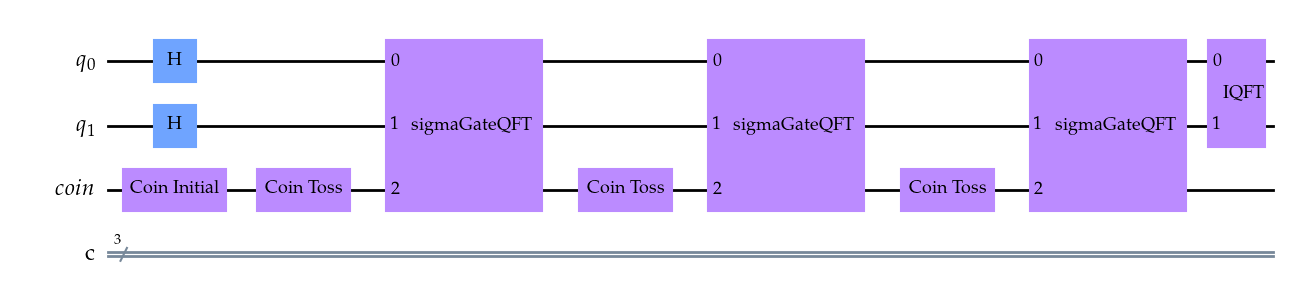

In [281]:
circuit = quantumWalkQFT(2,3,CoinInit, CoinToss)
circuit.draw('mpl')

In [283]:
transpiledCircuit=transpile(circuit,device)
#transpiledCircuit.draw('mpl')

### Exact simulations


In [284]:
#Nsite=4 #power of 2 site number
Nqubit=2
T=15

In [285]:
RE=[]
REall=[]
REcoin=[]

VNE=[]
for t in range(0,T):
    qc=quantumWalkQFT(Nqubit,t,CoinInit, CoinToss)
    vec=Statevector(qc)
    rhoRed=qi.partial_trace(vec,[Nqubit])
    rhoRedCoin=qi.partial_trace(vec,range(Nqubit))
    REall.append(-np.log2(vec.purity()))
    REcoin.append(-np.log2(rhoRed.purity()))
    RE.append(-np.log2(rhoRedCoin.purity()))

    VNE.append(qi.entropy(rhoRed))


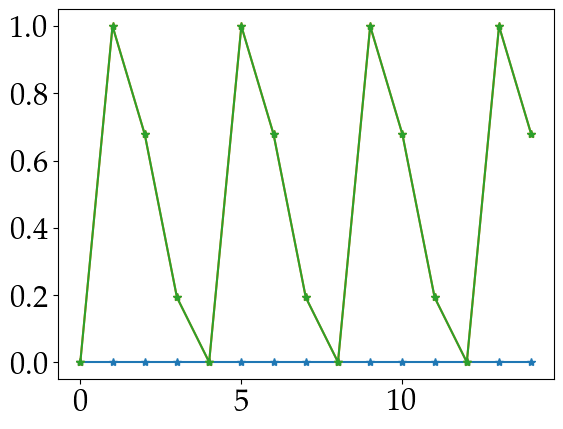

In [286]:
#Renyi entropy of the state, the coin and the walker, exact simulations
plt.plot(range(0,T),np.real(REall),'*-')
plt.plot(range(0,T),np.real(REcoin),'*-')
plt.plot(range(0,T),np.real(RE),'*-')
plt.show()

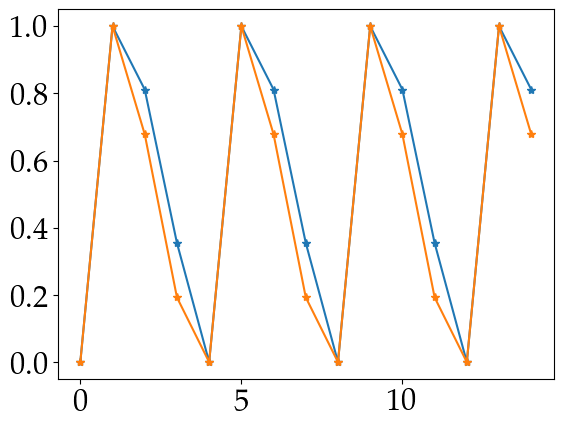

In [287]:
# Von Neuman Entropy VS Renyi Entropy
plt.plot(range(0,T),VNE,'*-')
plt.plot(range(0,T),np.real(RE),'*-')
plt.show()

### Noisy simulations

In [68]:

get_bin = lambda x, n: format(x, 'b').zfill(n) #return binary string of a decimal number
meas=[get_bin(i,Nqubit+1) for i in range(2**(Nqubit+1))]

#backend = QuantumInstance(simulator, shots=100000)
#sampler = Sampler(backend_options={ "coupling_map": coupling_map,"noise_model": noise_model,},run_options={"seed": 42, "shots": 100000},transpile_options={"seed_transpiler": 42})


In [17]:
Nqubit=2
T=15
Nmeas=100
shots=100000
REestCoinNoisy=[]
REestWalkerNoisy=[]
REestAllNoisy=[]
layout=[3,8,5]
simulator=sim_real

for t in range(0,T):
    pCoin=np.zeros((2,Nmeas))
    pAll=np.zeros((2**(Nqubit+1),Nmeas))
    pWalker=np.zeros((2**(Nqubit),Nmeas))

    for n in range(Nmeas):
        qc=quantumWalkQFT(Nqubit,t,CoinInit, CoinToss,measureAll=True)
        qc=randomMeasAll(qc,Nqubit)
        qct=transpile(qc,simulator,initial_layout=layout)
        counts=simulator.run(qct,shots=shots).result().get_counts()       

        for k in range(2**Nqubit):
            pWalker[k,n]=counts.get(meas[k],0)/shots + counts.get(meas[k+4],0)/shots
        for k in range(2**(Nqubit+1)):
            pAll[k,n]=counts.get(meas[k],0)/shots 
        for k in range(2):
            pCoin[k,n]=counts.get(meas[k],0)/shots +counts.get(meas[k+1],0)/shots +counts.get(meas[k+2],0)/shots +counts.get(meas[k+3],0)/shots 
        
    REestCoinNoisy.append(randomMeasEntropy(pCoin,1,Nmeas))
    REestWalkerNoisy.append(randomMeasEntropy(pWalker,Nqubit,Nmeas))
    REestAllNoisy.append(randomMeasEntropy(pAll,Nqubit+1,Nmeas))
    

In [241]:
shots=100000
countsVecNoisy=[]
Nqubit=2
layout=[3,8,5]
T=20

for t in range(0,T):
    qc=quantumWalkQFT(Nqubit,t,CoinInit, CoinToss,measureAll=False)
    qc.measure(qubit=range(Nqubit),cbit=range(Nqubit))
    qct=transpile(qc,sim_real,initial_layout=layout,optimization_level=1)
    counts=sim_real.run(qct,shots=shots).result().get_counts()       
    countsVecNoisy.append(counts)

countsVecIdeal=[]

for t in range(0,T):

    qc=quantumWalkQFT(Nqubit,t,CoinInit, CoinToss,measureAll=False)
    
    qc.measure(qubit=range(Nqubit),cbit=range(Nqubit))
    qct=transpile(qc,sim_ideal)
    counts=sim_ideal.run(qct,shots=shots).result().get_counts()    
    countsVecIdeal.append(counts)


In [ ]:

plt.figure(figsize=[16,12])
for i in range(5):
    for j in range(4):
     
        countsIdeal={'00':0,'01':0,'10':0,'11':0}
        countsIdeal.update(countsVecIdeal[i*4+j])
        countsNoisy={'00':0,'01':0,'10':0,'11':0}
        countsNoisy.update(countsVecNoisy[i*4+j])

        countsIdeal = {k: v / shots for k, v in countsIdeal.items()}
        countsNoisy = {k: v / shots for k, v in countsNoisy.items()}
        
        ax = plt.subplot2grid((5,4), (i,j))
        ax.bar(countsIdeal.keys(), countsIdeal.values(), align='edge',width=0.3,color='g')
        ax.bar(countsNoisy.keys(), countsNoisy.values(), align='edge',width=-0.3,color='b')
        ax.set_ylim(0,1)
        ax.grid()
        #ax.set_yticks([0,0.25,0.5,0.75,1])
        #ax.set_yticklabels(['0','2k','4k','6k','8k'])
        #ax.hist(countsVec[i*5+j])
plt.show()
   

In [ ]:
#plt.plot(range(0,T),VNE,'*-')
#Renyi entropy of the the walker, noisy simulations vs exact simulations
T=15
plt.plot(range(0,T),np.real(RE),'*-')
plt.plot(range(0,T),REestWalkerNoisy,'*-')
plt.show()

In [ ]:
#Renyi entropy of the state, the coin and the walker, exact simulations
T=15
plt.plot(range(0,T),np.real(REestAllNoisy),'r-*')
plt.plot(range(0,T),np.real(REestCoinNoisy),'b-*')
plt.plot(range(0,T),np.real(REestWalkerNoisy),'g-*')
#plt.axhline(y=3, color='r', linestyle='-',linewidth=2,label='Target')
#plt.axhline(y=2, color='g', linestyle='-',linewidth=2,label='Target')
#plt.axhline(y=1, color='b', linestyle='-',linewidth=2,label='Target')

plt.show()

## Actual Hardware

### Entanglement (DECEMBER 2023)

In [131]:

jobsID=['cn5m0583r3vg008fbx8g','cn5pb95daqbg008syh40','cn6y744ss5h00087kkf0','cn74m08anbvg008db5g0','cn782rv62r9000882b30','cn7bff5xhnxg008dm330','cn7jahass5h00087mwx0','cn7sb4wss5h00087n30g','cn8xbc5ss5h00087qjmg','cn8zpcst2wq0008c56mg','cn9jb4wpb7t0008r3dag','cn9mhpen6vt000848te0','cnf1dgyqcs7g008y7920','cnfg0qtzyx9g008qf8yg','cnfk4608jfe0008g3dxg']


In [132]:
Nmeas=300
Nqubit=2
T=15
shots=100000
RErealCoin=[]
RErealWalker=[]
RErealAll=[]
get_bin = lambda x, n: format(x, 'b').zfill(n) #return binary string of a decimal number
meas=[get_bin(i,Nqubit+1) for i in range(2**(Nqubit+1))]

for jobID in jobsID:
    job = provider.retrieve_job(jobID)
    result = job.result()
    counts = result.get_counts()
    pCoin=np.zeros((2,Nmeas))
    pAll=np.zeros((2**(Nqubit+1),Nmeas))
    pWalker=np.zeros((2**(Nqubit),Nmeas))

    for n in range(Nmeas):
        count=counts[n]
       
        for k in range(2**Nqubit):
            pWalker[k,n]=count.get(meas[k],0)/shots + count.get(meas[k+4],0)/shots
        for k in range(2**(Nqubit+1)):
            pAll[k,n]=count.get(meas[k],0)/shots 
        for k in range(2):
            pCoin[k,n]=count.get(meas[k],0)/shots +count.get(meas[k+1],0)/shots +count.get(meas[k+2],0)/shots +count.get(meas[k+3],0)/shots 
        
    RErealCoin.append(randomMeasEntropy(pCoin,1,Nmeas))
    RErealWalker.append(randomMeasEntropy(pWalker,Nqubit,Nmeas))
    RErealAll.append(randomMeasEntropy(pAll,Nqubit+1,Nmeas))

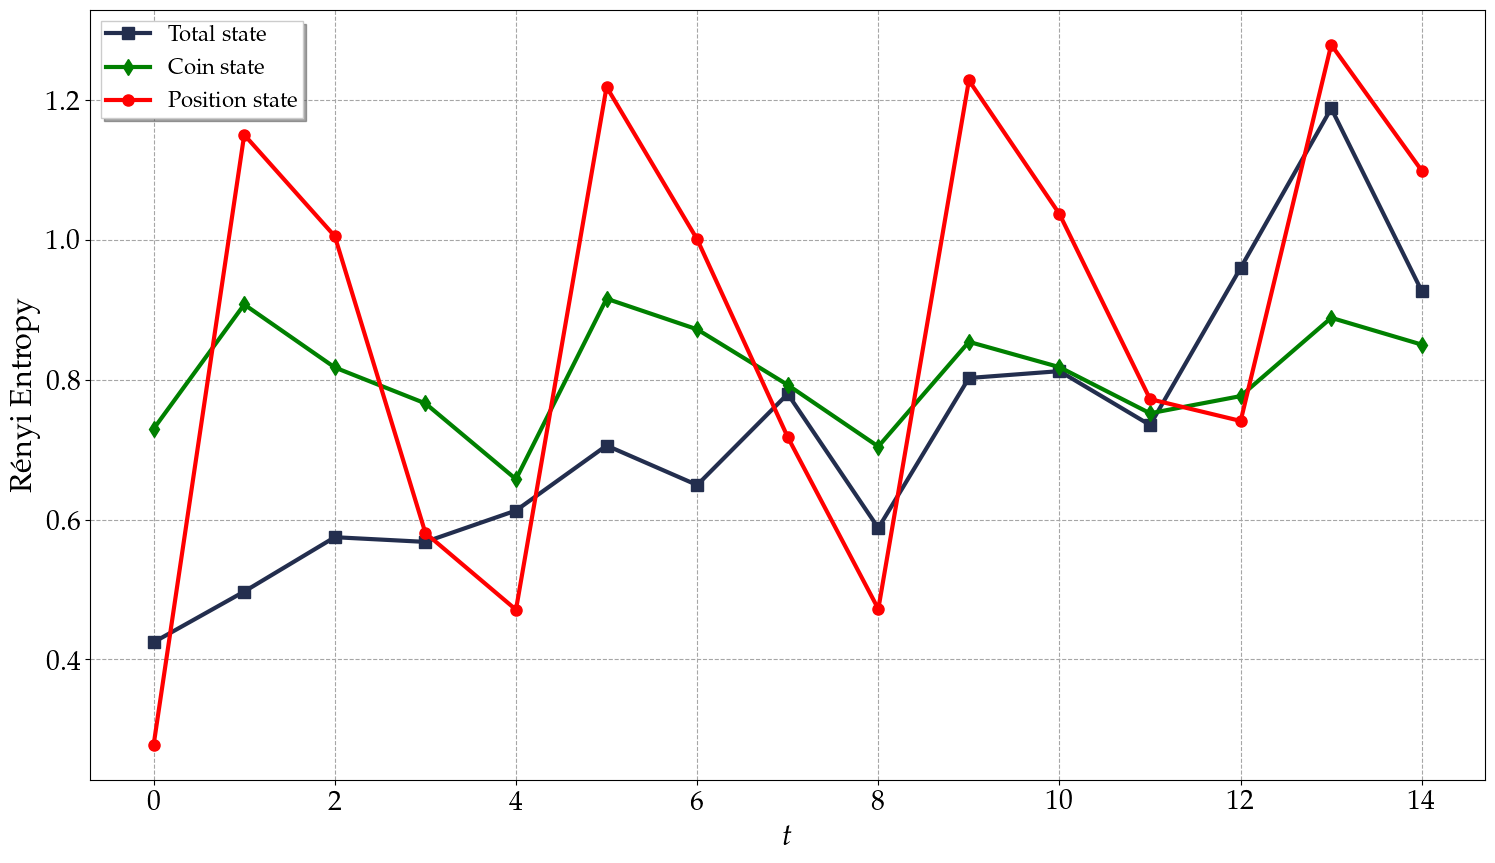

In [133]:
#Renyi entropy of the state, the coin and the walker, PAREC actual hardware
T=15

#plt.axhline(y=3, color='r', linestyle='-',linewidth=2,label='Target')
#plt.axhline(y=2, color='g', linestyle='-',linewidth=2,label='Target')
#plt.axhline(y=1, color='b', linestyle='-',linewidth=2,label='Target')

plt.figure(figsize=[18,10])
plt.rcParams["font.size"] = 22
#plt.subplot(121)
#plt.ylim([-0.005,0.55])
#plt.xlim([-10,10])

plt.plot(range(0,T),np.real(RErealAll),'-s',color='#232E4E',linewidth=3,label='Total state',markersize=8)
plt.plot(range(0,T),np.real(RErealCoin),'g-d',linewidth=3,label='Coin state',markersize=8)
plt.plot(range(0,T),np.real(RErealWalker),'r-o',linewidth=3,label='Position state',markersize=8)

#plt.plot(range(0,T),np.real(RE),'r--o',linewidth=1.6,label=' Theoretical Walker Entropy')



plt.grid(True, which='both',ls='--',color='0.65')
plt.tick_params(axis='both',labelsize=20)

plt.legend(fontsize=16, borderpad=0.2,fancybox=False,shadow=True)
plt.ylabel('Rényi Entropy')
plt.xlabel('$t$')
plt.xticks([0,2,4,6,8,10,12,14])

plt.savefig('DTQW_n2_Entropies_DICEMBRE.svg',format='svg',dpi=1200 ,bbox_inches = 'tight')

plt.show()


### Simulations with sampler


In [ ]:
service = QiskitRuntimeService(channel="ibm_quantum")
simulator = service.backend("ibmq_qasm_simulator")
backend=service.backend("ibm_cairo")

session = Session(service=service, backend=backend)


In [15]:

options = Options()
options.execution.shots = 100000
options.optimization_level = 1
options.resilience_level=0

samplerSimulator = Sampler(backend=simulator,options=options)

In [16]:
from datetime import datetime
provider = IBMProvider(instance="ibm-q-cern/infn/qcqcd1")
device = provider.get_backend("ibm_cairo")
t = datetime(day=1, month=12, year=2023, hour=21)
prop = device.properties(datetime=t)


In [17]:
noise_model = NoiseModel.from_backend_properties(prop)
coupling_map = device.configuration().coupling_map
basis_gates=device.configuration().basis_gates

options_with_nm = Options()
options_with_nm.simulator = {
    "noise_model": noise_model,
    "basis_gates": basis_gates,
    "coupling_map": coupling_map,
    "seed_simulator": 42
}

# Set number of shots, optimization_level and resilience_level
options_with_nm.execution.shots = 100000
options_with_nm.optimization_level = 1 # no optimization
options_with_nm.resilience_level = 0 # M3 for Sampler and T-REx for Estimator

samplerNoisy=Sampler(backend=simulator,options=options_with_nm)

In [18]:
options = Options()
options.execution.shots = 100000
options.optimization_level = 3
options.resilience_level=0

samplerCairo = Sampler(backend=backend,options=options)

### n=2

In [ ]:
CoinInit=QuantumCircuit(1,name='Coin Initial')
CoinInit.u(np.pi/6,np.pi/2,0,[0])

CoinToss=QuantumCircuit(1,name='Coin Toss')
CoinToss.u(np.pi/2,2*np.pi,np.pi,[0]) # hadamard coin
Nqubit=2

#CoinToss=qi.random_unitary(2)

qcList=[]
T=20
for t in range(0,T):
    qc=quantumWalkQFT(Nqubit,t,CoinInit, CoinToss,measureAll=False)
    qc.measure(qubit=range(Nqubit),cbit=range(Nqubit))
    qcList.append(qc) 

layout=[3,8,5] #physical qubits mapping
qcListTranspiled=transpile(qcList,backend=device,optimization_level=3,initial_layout=layout)

In [45]:
job=samplerSimulator.run(qcList)

In [48]:
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cmfuh3brga5j1u9uo0bg
>>> Job Status: JobStatus.DONE


In [49]:
result=job.result()
CountsIdeal2=result.quasi_dists

In [77]:
job=samplerNoisy.run(qcListTranspiled)

In [80]:
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cmfujjsnktricignn3eg
>>> Job Status: JobStatus.DONE


In [81]:
result=job.result()
CountsNoisyShakeel2=result.quasi_dists

In [15]:
job=samplerCairo.run(qcListTranspiled)

In [ ]:
job=service.job('cnmv8es24wx0008f98g0')

In [59]:
result=job.result()
CountsReal2=result.quasi_dists

In [ ]:
job=service.job('cnmv8kj24wx0008f98gg')

In [62]:
result=job.result()
CountsRealOpt2=result.quasi_dists

In [ ]:
FidelityNoisyShak=[]
FidelityNoisy=[]
FidelityReal=[]
FidelityRealCorr=[]


for i in range(20): 
 
     
    countsIdeal={0:0,1:0,2:0,3:0}
    countsIdeal.update(CountsIdeal2[i])        
    countsNoisy={0:0,1:0,2:0,3:0}
    countsNoisy.update(CountsNoisy2[i])
    countsNoisyShak={0:0,1:0,2:0,3:0}
    countsNoisyShak.update(CountsNoisyShakeel2[i])
    countsReal={0:0,1:0,2:0,3:0}
    countsReal.update(CountsReal2[i])
    countsRealCorr={0:0,1:0,2:0,3:0}
    countsRealCorr.update(CountsRealOpt2[i])

    FidelityNoisy.append(qi.hellinger_fidelity(countsIdeal,countsNoisy))
    FidelityNoisyShak.append(qi.hellinger_fidelity(countsIdeal,countsNoisyShak))
    FidelityReal.append(qi.hellinger_fidelity(countsIdeal,countsReal))
    FidelityRealCorr.append(qi.hellinger_fidelity(countsRealCorr,countsIdeal))

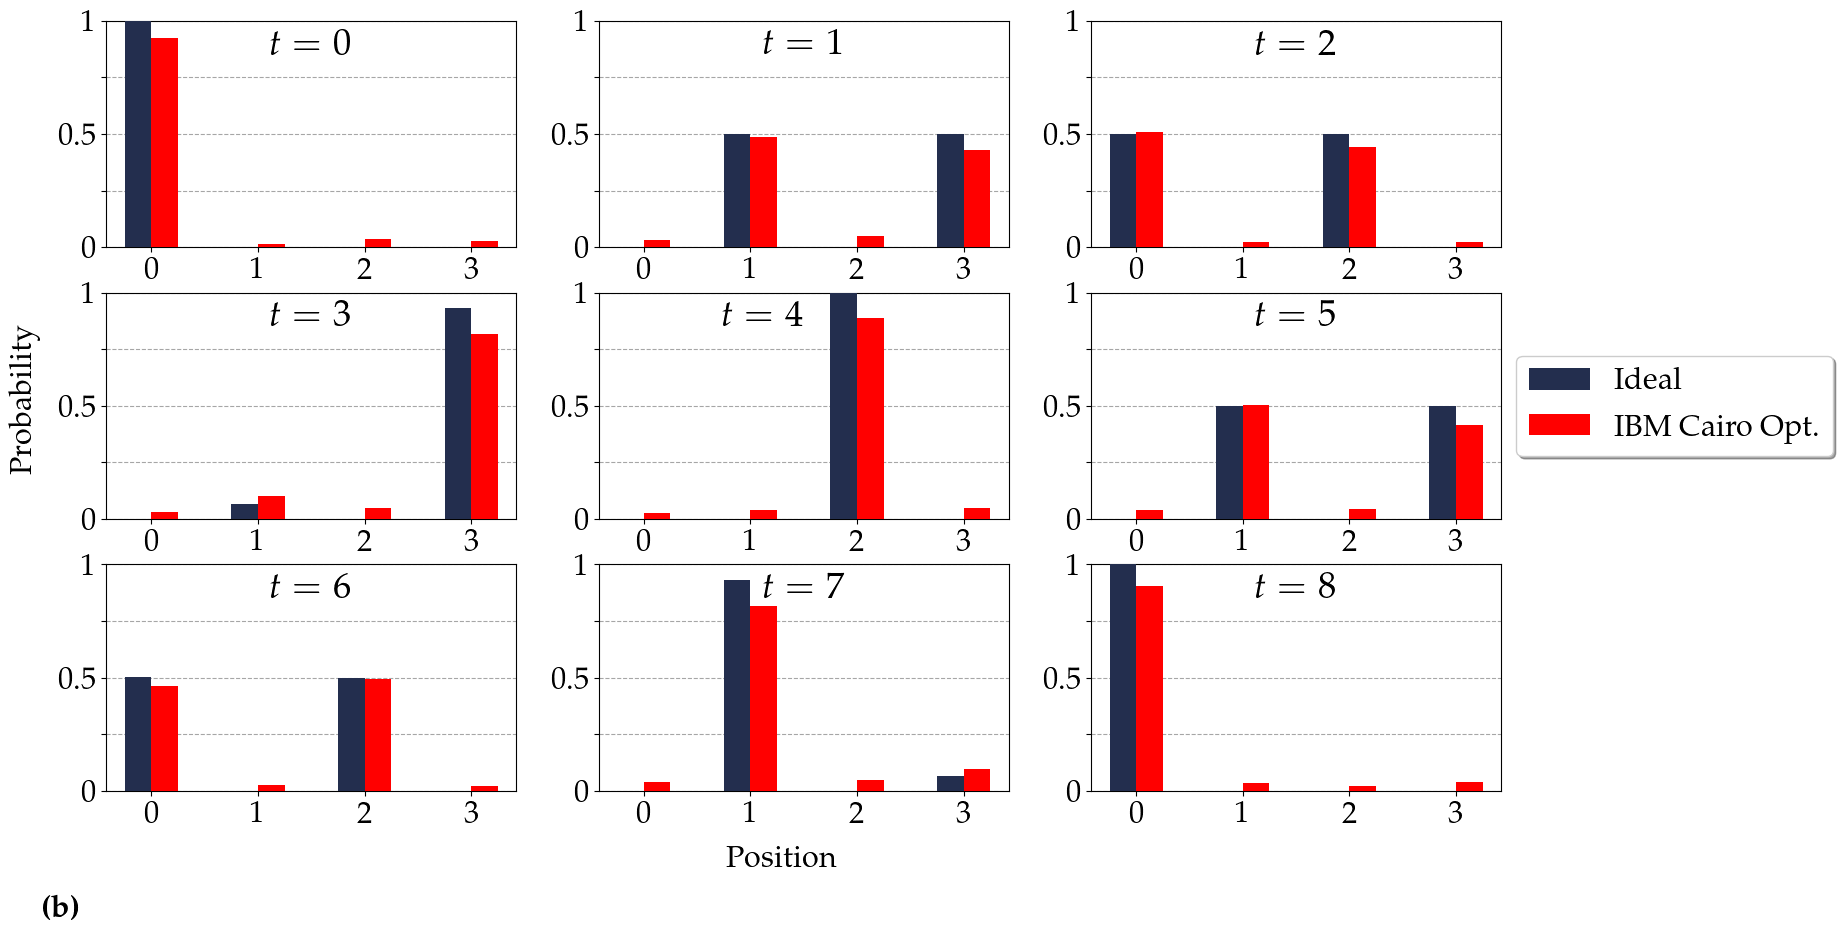

In [83]:

fig=plt.figure(figsize=[18,10])

plots = []
titles=['$t=0$','$t=1$','$t=2$','$t=3$','$t=4$','$t=5$','$t=6$','$t=7$','$t=8$']

#ax = plt.subplot2grid((6,3), (0,0),rowspan=2, colspan=3)
#ax.plot(range(0,20),FidelityNoisy,'-s',color='#232E4E',linewidth=2.5,label='Noisy simulation')
#plt.rcParams["font.size"] = 22
#plt.subplot(121)
#ax.set_ylim([0,1])
#plt.xlim([-10,10])
#ax.plot(range(0,20),FidelityNoisy,'-s',color='#232E4E',linewidth=2.5,label='Noisy simulation')
#ax.plot(range(0,20),FidelityNoisyShak,'-p',color='g',linewidth=2.5,label='Noisy simulation (QFT-scheme)')
#ax.plot(range(0,20),FidelityReal,'--d',color='#232E4E',linewidth=2.5,label='IBM Cairo')
#ax.plot(range(0,20),FidelityRealCorr,'r-o',linewidth=2.5,label='IBM Cairo Opt.')

#ax.grid(True, which='both',ls='--',color='0.65')
#ax.tick_params(axis='both',labelsize=20)

#ax.legend(fontsize=16, borderpad=0.2,fancybox=False,shadow=True)
#ax.set_ylabel('$\mathcal{H}$')
#ax.set_xlabel('$t$')

for i in range(3): 
    for j in range(3):
     
        countsIdeal={0:0,1:0,2:0,3:0}
        countsIdeal.update(CountsIdeal2[i*3+j])
        countsNoisy={0:0,1:0,2:0,3:0}
        countsNoisy.update(CountsNoisy2[i*3+j])
        countsNoisyShak={0:0,1:0,2:0,3:0}
        countsNoisyShak.update(CountsNoisyShakeel2[i*3+j])
        countsReal={0:0,1:0,2:0,3:0}
        countsReal.update(CountsReal2[i*3+j])
        countsRealCorr={0:0,1:0,2:0,3:0}
        countsRealCorr.update(CountsRealOpt2[i*3+j])

       
        width=0.25
    
        ax = plt.subplot2grid((3,3), (i,j))
        ax.grid(True, axis='y',ls='--',color='0.65')
        ax.bar(np.array([1,2,3,4])-0.125, countsIdeal.values(),width=width,color='#232E4E',label='Ideal',zorder=3)
        #ax.bar(np.array([1,2,3,4]), countsReal.values(),width=width,color='b')
        ax.bar(np.array([1,2,3,4])+0.125, countsRealCorr.values(),width=width,color='r',label='IBM Cairo Opt.',zorder=3)
        ax.set_ylim(0,1)
        
        ax.set_xticks([1,2,3,4])
        ax.set_xticklabels(['0','1','2','3'])
        if i*3+j==4:
            ax.set_title(titles[i*3+j],x=0.3,y=1, pad=-24,loc='left')
        else:
            ax.set_title(titles[i*3+j],y=1, pad=-24)
       
        ax.set_yticks([0,0.25,0.5,0.75,1])
        ax.set_yticklabels(['0','','0.5','','1'])

ax.legend(loc='center left', bbox_to_anchor=(1, 1.7),ncol=1, fancybox=True, shadow=True)
fig.text(0.5, 0.04, 'Position', va='center', ha='center')
fig.text(0.08, 0.5, 'Probability', va='center', ha='center', rotation='vertical')

fig.text(0.1, -0.01, '\\textbf{(b)}', va='center', ha='center')
#plt.savefig('DTQW_n2_dist.svg',format='svg',dpi=1200, bbox_inches = 'tight')
plt.show()

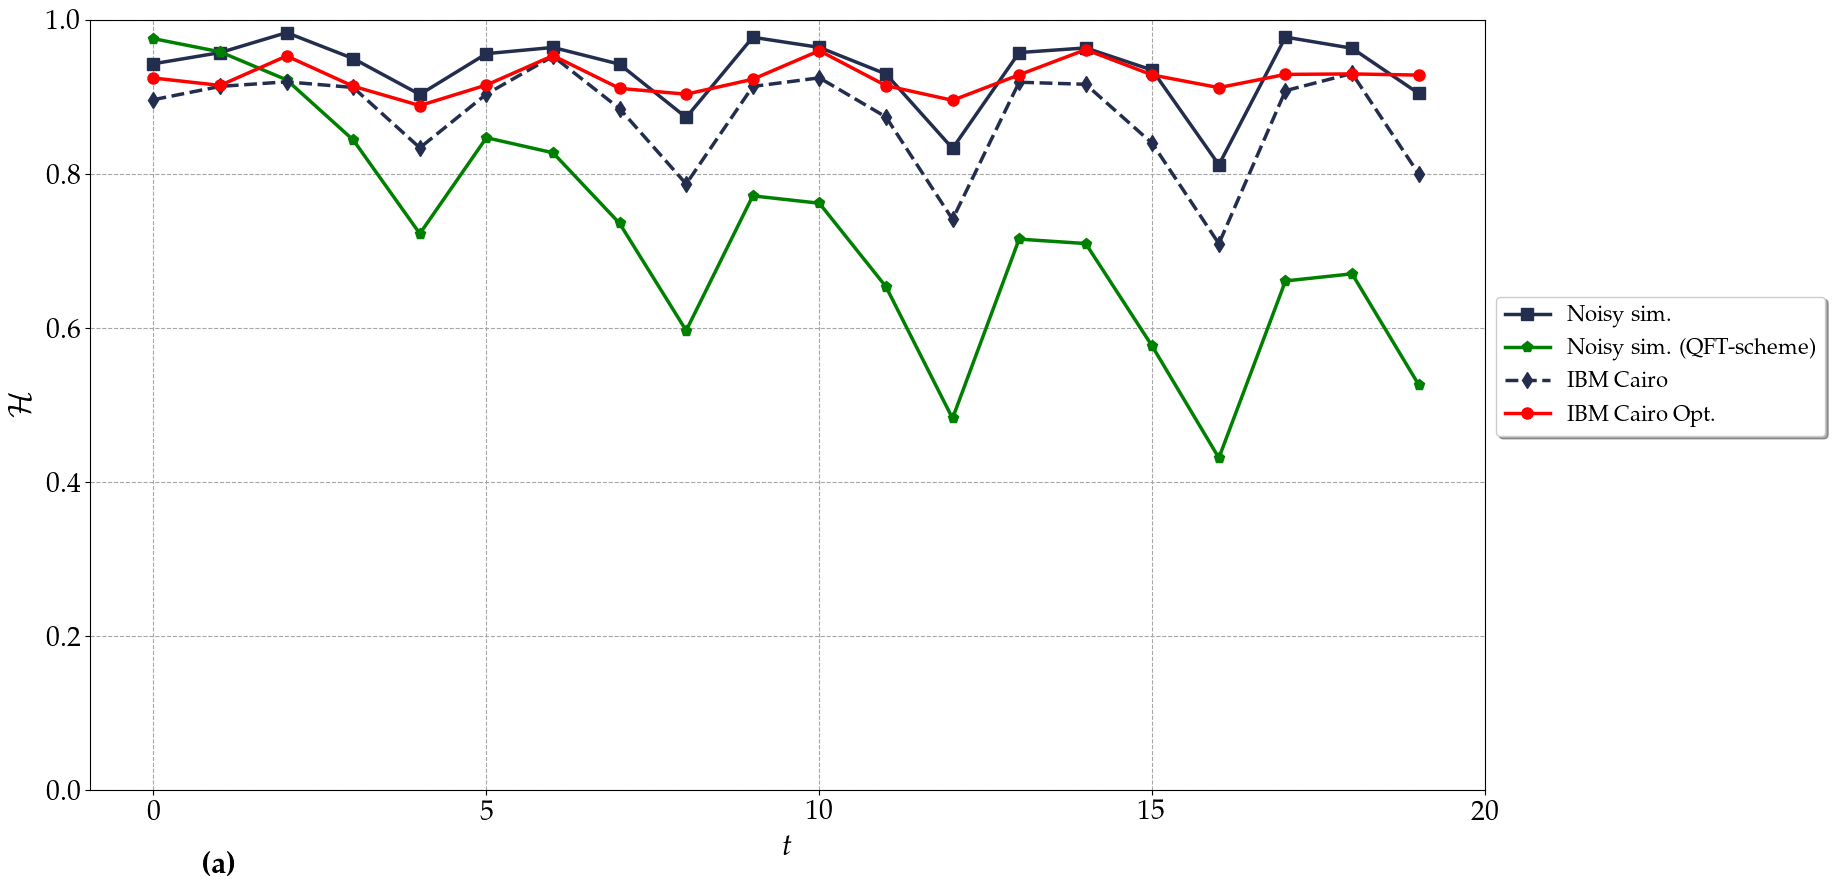

In [84]:
# Hellinger fidelities, noisy simulation and hardware

plt.figure(figsize=[18,10])
plt.rcParams["font.size"] = 22
#plt.subplot(121)
plt.ylim([0,1])
#plt.xlim([-10,10])
plt.plot(range(0,20),FidelityNoisy,'-s',color='#232E4E',linewidth=2.5,label='Noisy sim.',markersize=8)
plt.plot(range(0,20),FidelityNoisyShak,'-p',color='g',linewidth=2.5,label='Noisy sim. (QFT-scheme)',markersize=8)
plt.plot(range(0,20),FidelityReal,'--d',color='#232E4E',linewidth=2.5,label='IBM Cairo',markersize=8)
plt.plot(range(0,20),FidelityRealCorr,'r-o',linewidth=2.5,label='IBM Cairo Opt.',markersize=8)

plt.grid(True, which='both',ls='--',color='0.65')
plt.tick_params(axis='both',labelsize=20)

#plt.legend(fontsize=16, borderpad=0.2,fancybox=False,shadow=True)
plt.xticks([0,5,10,15,20])

plt.legend(fontsize=16,loc='center left', bbox_to_anchor=(1, 0.55),ncol=1, fancybox=True, shadow=True)
plt.ylabel('$\mathcal{H}$')
plt.xlabel('$t$')
plt.text(1, -0.1, '\\textbf{(a)}', va='center', ha='center')
#plt.savefig('DTQW_n2_HellingerFid.svg',format='svg',dpi=1200,bbox_inches = 'tight')



plt.show()

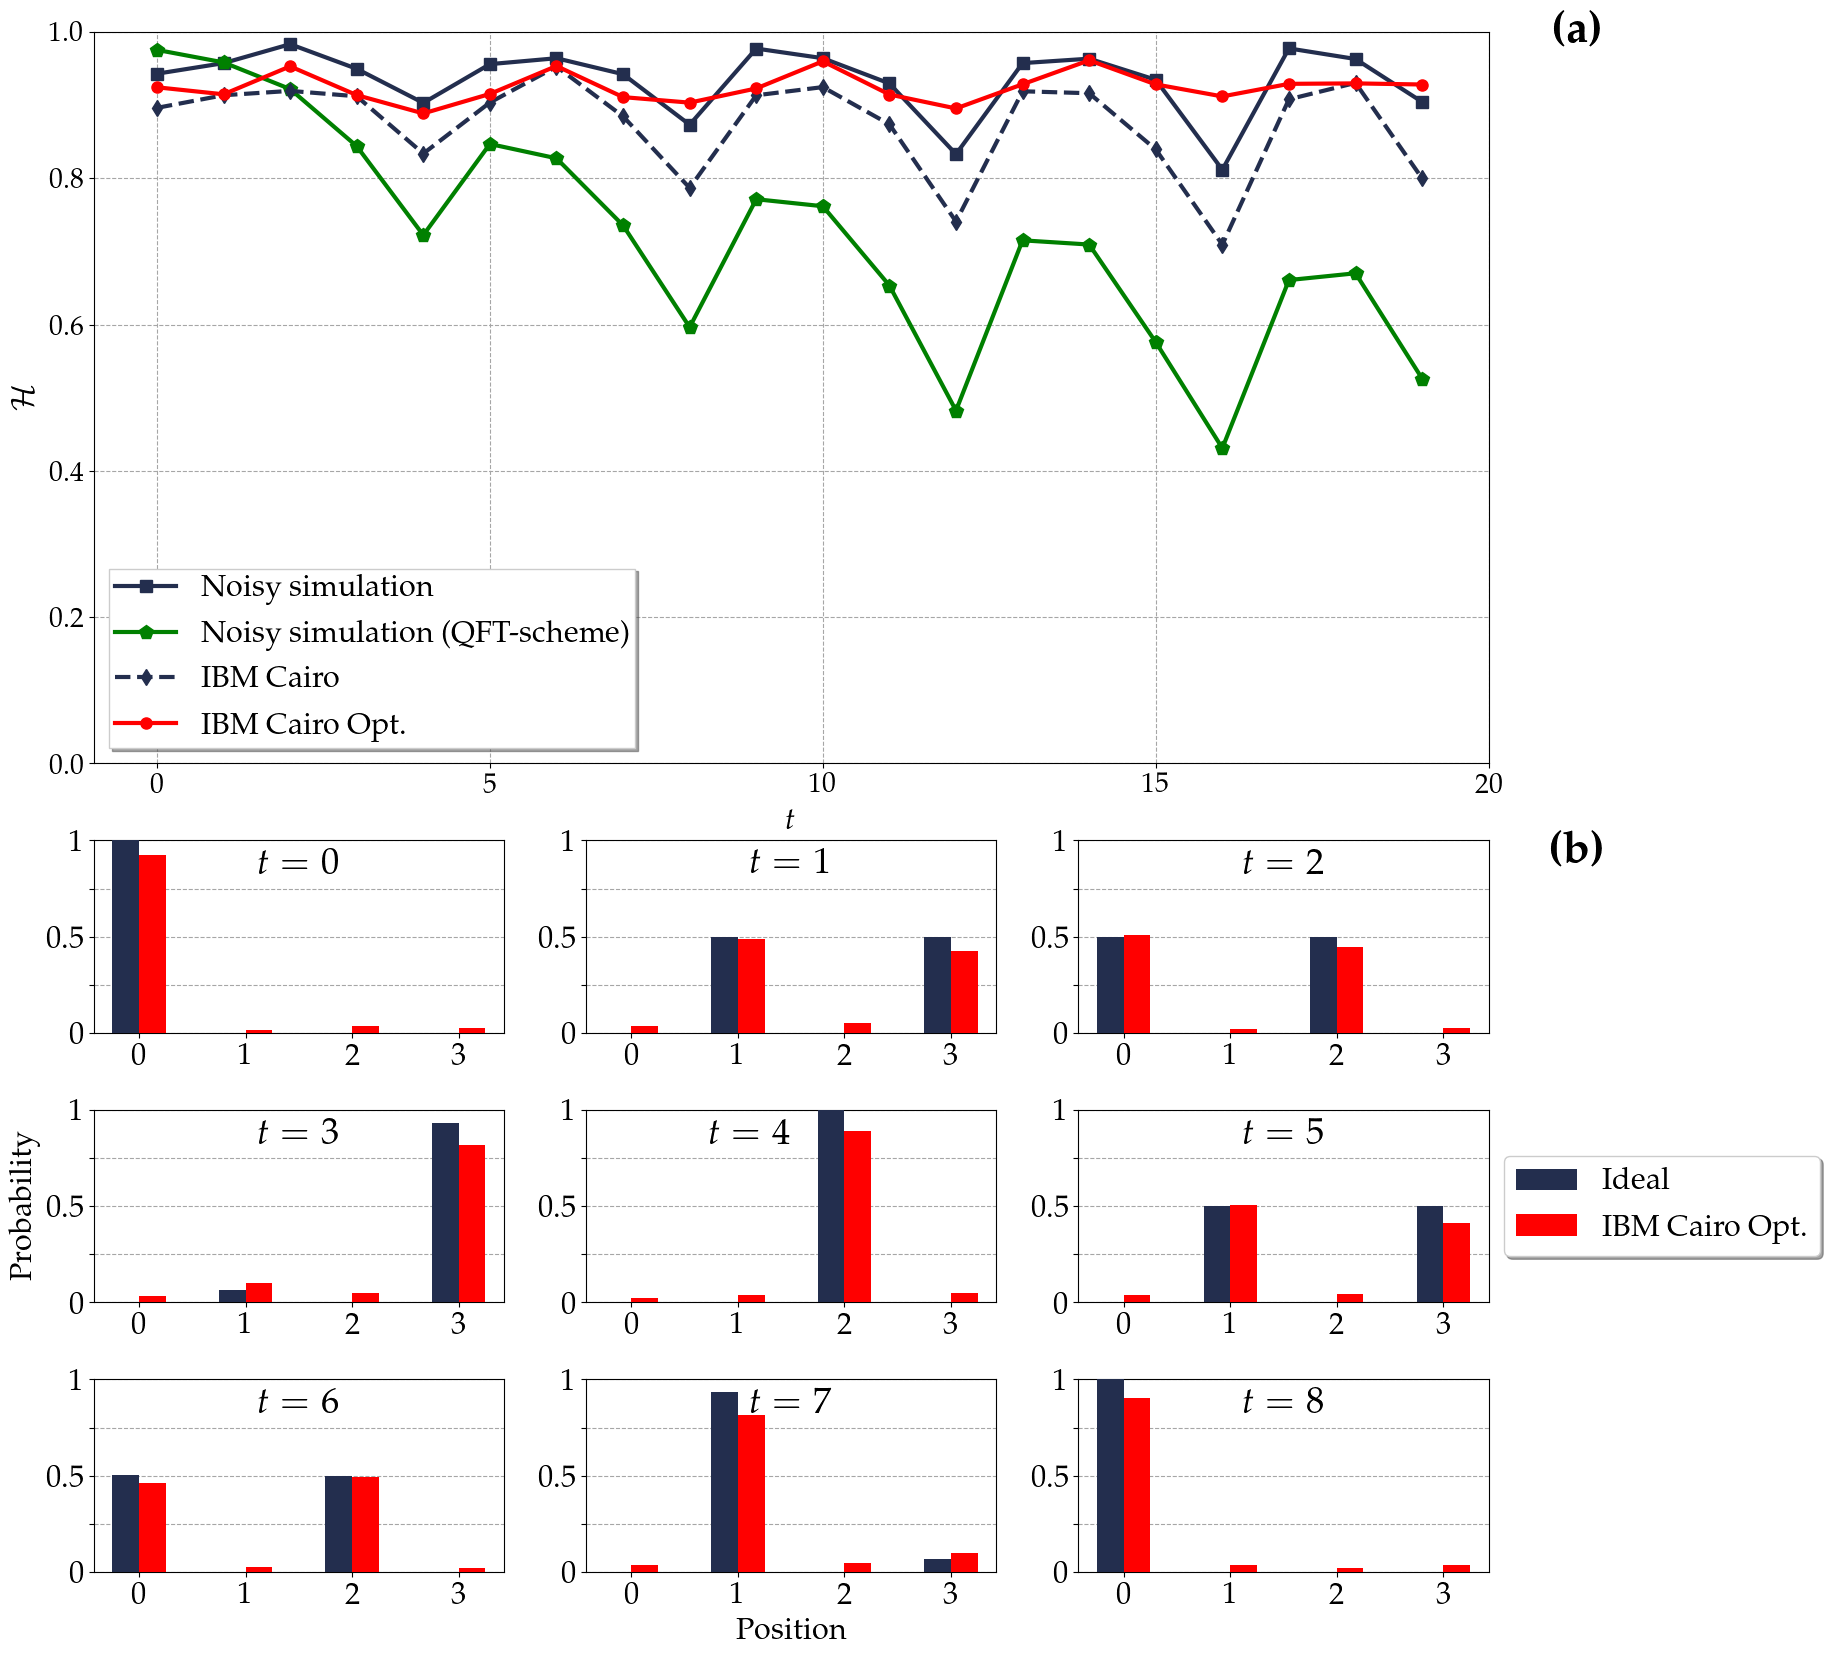

In [159]:

fig=plt.figure(figsize=[18,20])

plots = []
titles=['$t=0$','$t=1$','$t=2$','$t=3$','$t=4$','$t=5$','$t=6$','$t=7$','$t=8$']

ax = plt.subplot2grid((6,3), (0,0),rowspan=3, colspan=3)

plt.rcParams["font.size"] = 22
#plt.subplot(121)
ax.set_ylim([0,1])
#plt.xlim([-10,10])
ax.plot(range(0,20),FidelityNoisy,'-s',color='#232E4E',linewidth=3,label='Noisy simulation',markersize=8)
ax.plot(range(0,20),FidelityNoisyShak,'-p',color='g',linewidth=3,label='Noisy simulation (QFT-scheme)',markersize=10)
ax.plot(range(0,20),FidelityReal,'--d',color='#232E4E',linewidth=3,label='IBM Cairo',markersize=8)
ax.plot(range(0,20),FidelityRealCorr,'r-o',linewidth=3,label='IBM Cairo Opt.',markersize=8)

ax.grid(True, which='both',ls='--',color='0.65')
ax.tick_params(axis='both',labelsize=20)

ax.legend(borderpad=0.2,fancybox=False,shadow=True)
ax.set_ylabel('$\mathcal{H}$')
ax.set_xlabel('$t$')
ax.set_xticks([0,5,10,15,20])
plt.subplots_adjust(hspace=0.4)
for i in range(3): 
    for j in range(3):
     
        countsIdeal={0:0,1:0,2:0,3:0}
        countsIdeal.update(CountsIdeal2[i*3+j])
        countsNoisy={0:0,1:0,2:0,3:0}
        countsNoisy.update(CountsNoisy2[i*3+j])
        countsNoisyShak={0:0,1:0,2:0,3:0}
        countsNoisyShak.update(CountsNoisyShakeel2[i*3+j])
        countsReal={0:0,1:0,2:0,3:0}
        countsReal.update(CountsReal2[i*3+j])
        countsRealCorr={0:0,1:0,2:0,3:0}
        countsRealCorr.update(CountsRealOpt2[i*3+j])

       
        width=0.25
    
        ax = plt.subplot2grid((6,3), (3+i,j))
        ax.grid(True, axis='y',ls='--',color='0.65')
        ax.bar(np.array([1,2,3,4])-0.125, countsIdeal.values(),width=width,color='#232E4E',label='Ideal',zorder=3)
        #ax.bar(np.array([1,2,3,4]), countsReal.values(),width=width,color='b')
        ax.bar(np.array([1,2,3,4])+0.125, countsRealCorr.values(),width=width,color='r',label='IBM Cairo Opt.',zorder=3)
        ax.set_ylim(0,1)
        
        ax.set_xticks([1,2,3,4])
        ax.set_xticklabels(['0','1','2','3'])

        if i*3+j==3:
            ax.set_ylabel('Probability')
        if i*3+j==7:
            ax.set_xlabel('Position')

        if i*3+j==4:
            ax.set_title(titles[i*3+j],x=0.3,y=1, pad=-24,loc='left')
        else:
            ax.set_title(titles[i*3+j],y=1, pad=-24)
       
        ax.set_yticks([0,0.25,0.5,0.75,1])
        ax.set_yticklabels(['0','','0.5','','1'])

ax.legend(loc='center left', bbox_to_anchor=(1, 1.9),ncol=1, fancybox=True, shadow=True)
#fig.text(0.5, 0.04, 'Position', va='center', ha='center')
#fig.text(0.08, 0.5, 'Probability', va='center', ha='center', rotation='vertical')

fig.text(0.95, 0.88, '\\textbf{(a)}', va='center', ha='center',fontsize=32)
fig.text(0.95, 0.47, '\\textbf{(b)}', va='center', ha='center',fontsize=32)
plt.savefig('DTQW_n2.svg',format='svg',dpi=1200, bbox_inches = 'tight')


plt.show()

### n=3

In [16]:
CoinInit=QuantumCircuit(1,name='Coin Initial')
CoinInit.u(np.pi/6,np.pi/2,0,[0])

CoinToss=QuantumCircuit(1,name='Coin Toss')
CoinToss.u(np.pi/2,2*np.pi,np.pi,[0]) # hadamard coin
Nqubit=3

#CoinToss=qi.random_unitary(2)

qcList=[]
T=30
for t in range(0,T):
    qc=quantumWalkQFT(Nqubit,t,CoinInit, CoinToss,measureAll=False)
    qc.measure(qubit=range(Nqubit),cbit=range(Nqubit))
    qcList.append(qc) 

layout=[10,13,15,12] #physical qubits mapping
qcListTranspiled=transpile(qcList,backend=device,optimization_level=1,initial_layout=layout)

In [131]:
job=samplerSimulator.run(qcList)

In [133]:
result=job.result()
CountsIdeal3=result.quasi_dists

In [138]:
job=samplerNoisy.run(qcListTranspiled)

In [140]:
result=job.result()
#CountsNoisy3=result.quasi_dists
CountsNoisyShakeel3=result.quasi_dists

In [17]:
job=samplerCairo.run(qcListTranspiled)

In [141]:
job=service.job('cnmva70pzmsg008wvxeg')

In [143]:
result=job.result()
CountsReal3=result.quasi_dists

In [144]:
job=service.job('cnmvabs0k0p00088szx0')

In [146]:
result=job.result()
CountsRealOpt3=result.quasi_dists

In [147]:
job=service.job('cnmvb740k0p00088t00g')

In [149]:
result=job.result()
CountsRealOptCorr3=result.quasi_dists

In [160]:

plt.figure(figsize=[16,12])

plots = []
FidelityNoisy=[]
FidelityNoisyShak=[]
FidelityReal=[]
FidelityRealOptCorr=[]
FidelityRealOpt=[]

for i in range(6):
    for j in range(5):
     
        countsIdeal={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0}
        countsIdeal.update(CountsIdeal3[i*5+j])
        countsNoisy={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0}
        countsNoisy.update(CountsNoisy3[i*5+j])
        countsNoisyShak={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0}
        countsNoisyShak.update(CountsNoisyShakeel3[i*5+j])
        countsReal={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0}
        countsReal.update(CountsReal3[i*5+j])
        countsRealOpt={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0}
        countsRealOpt.update(CountsRealOpt3[i*5+j])
        countsRealCorr={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0}
        countsRealCorr.update(CountsRealOptCorr3[i*5+j])

        
        
        FidelityNoisy.append(qi.hellinger_fidelity(countsIdeal,countsNoisy))
        FidelityNoisyShak.append(qi.hellinger_fidelity(countsIdeal,countsNoisyShak))
        FidelityReal.append(qi.hellinger_fidelity(countsIdeal,countsReal))
        FidelityRealOpt.append(qi.hellinger_fidelity(countsRealOpt,countsIdeal))
        FidelityRealOptCorr.append(qi.hellinger_fidelity(countsRealCorr,countsIdeal))


<Figure size 1600x1200 with 0 Axes>

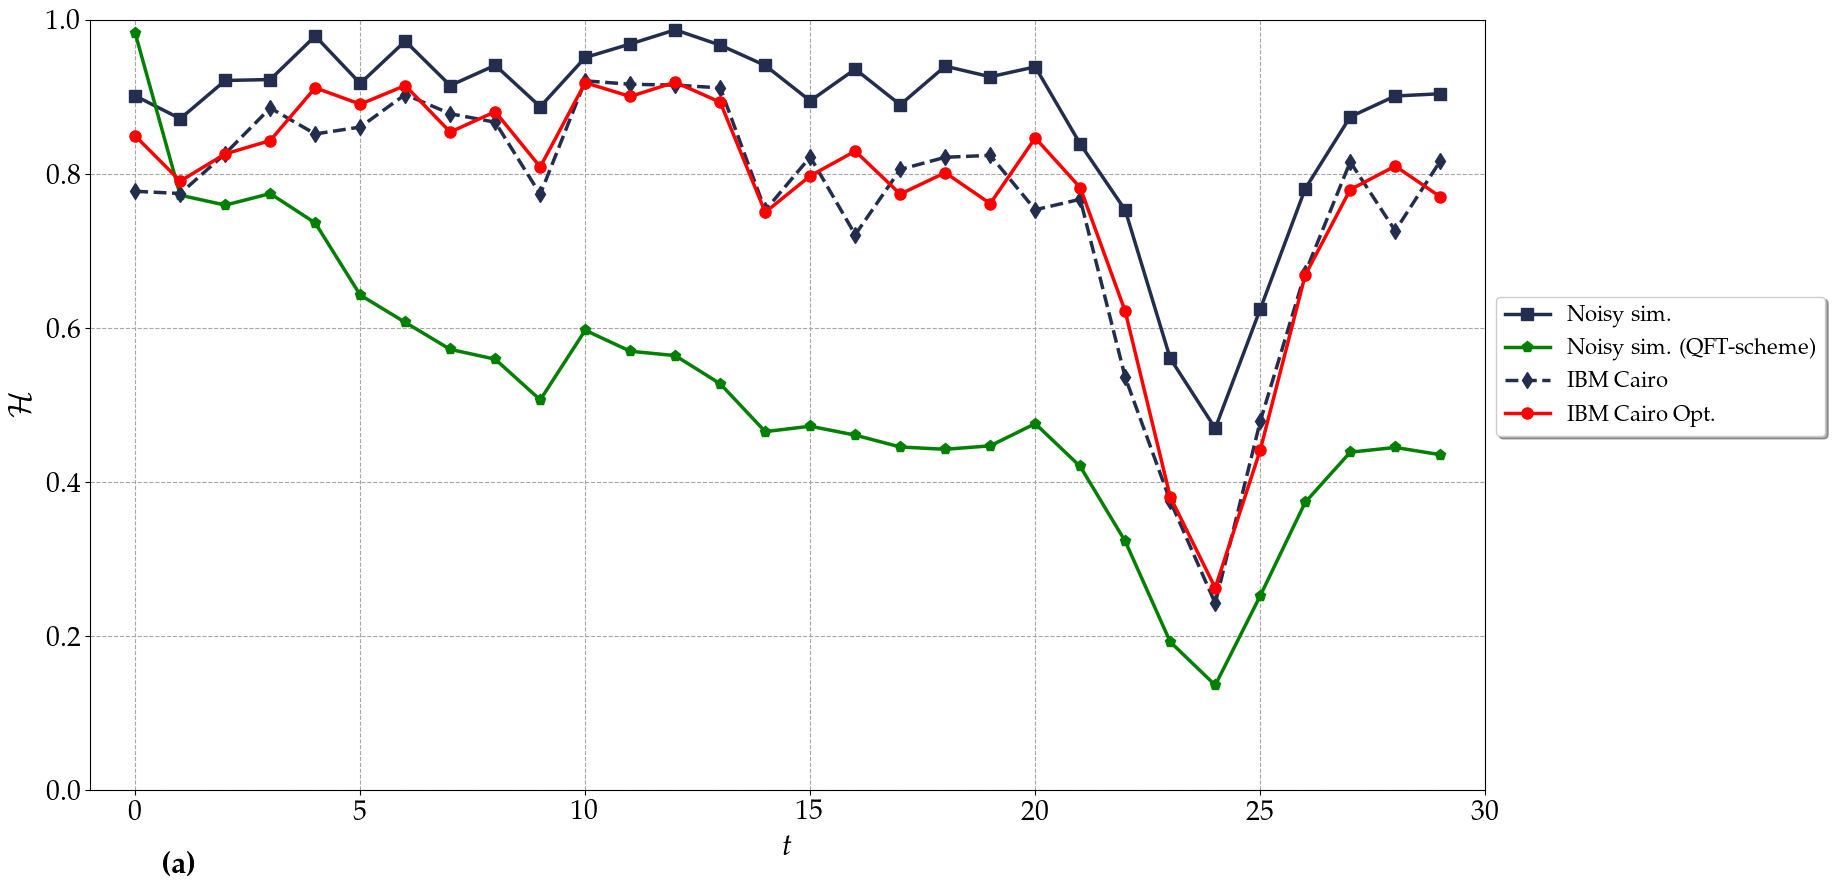

In [151]:
# Hellinger fidelities, noisy simulation and hardware

plt.figure(figsize=[18,10])
plt.rcParams["font.size"] = 22
#plt.subplot(121)
plt.ylim([0,1])
plt.xlim([-1,30])
plt.plot(range(0,30),FidelityNoisy,'-s',color='#232E4E',linewidth=2.5,label='Noisy sim.',markersize=8)
plt.plot(range(0,30),FidelityNoisyShak,'-p',color='g',linewidth=2.5,label='Noisy sim. (QFT-scheme)',markersize=8)
plt.plot(range(0,30),FidelityReal,'--d',color='#232E4E',linewidth=2.5,label='IBM Cairo',markersize=8)
plt.plot(range(0,30),FidelityRealOpt,'r-o',linewidth=2.5,label='IBM Cairo Opt.',markersize=8)
#plt.plot(range(0,30),FidelityRealOptCorr,'g--o',linewidth=2.5,label='IBM Cairo Opt Corr')

plt.grid(True, which='both',ls='--',color='0.65')
plt.tick_params(axis='both',labelsize=20)

plt.legend(fontsize=16,loc='center left', bbox_to_anchor=(1, 0.55),ncol=1, fancybox=True, shadow=True)
plt.ylabel('$\mathcal{H}$')
plt.xlabel('$t$')
plt.text(1, -0.1, '\\textbf{(a)}', va='center', ha='center')
#plt.savefig('DTQW_n3_HellingerFid.svg',format='svg',dpi=1200,bbox_inches = 'tight')

plt.show()

Text(0.1, -0.01, '\\textbf{(b)}')

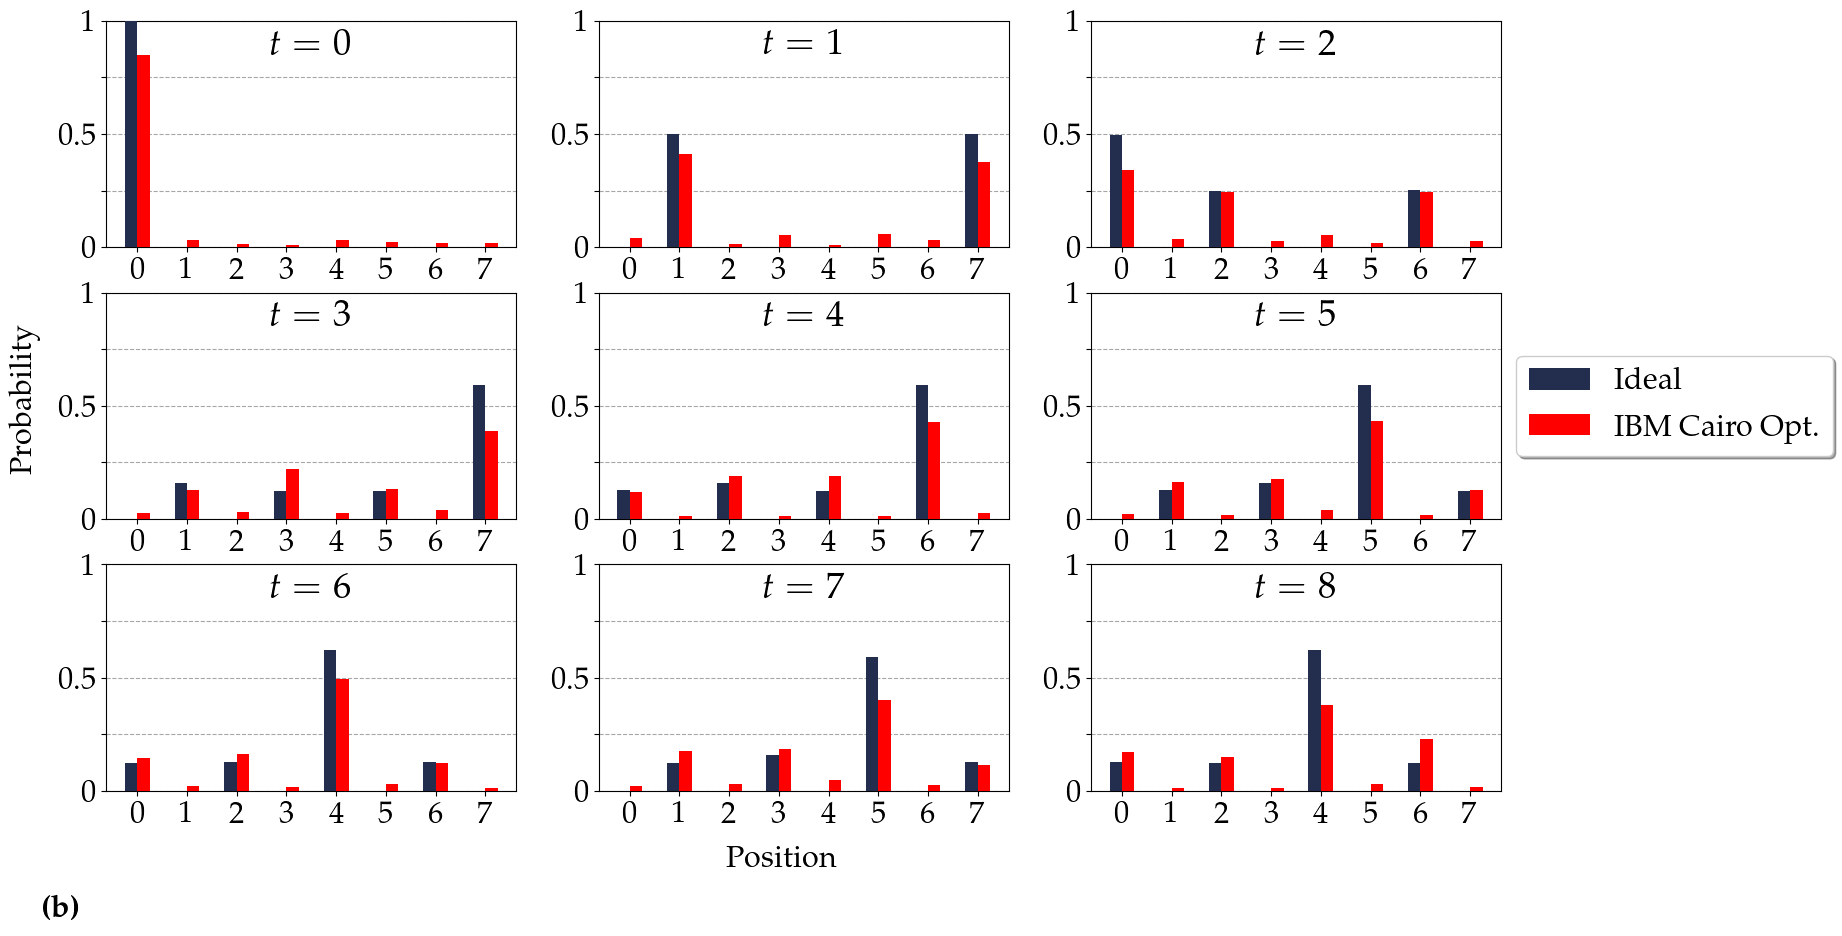

In [152]:


fig=plt.figure(figsize=[18,10])


# hide tick and tick label of the big axis

plots = []


prova=[]
titles=['$t=0$','$t=1$','$t=2$','$t=3$','$t=4$','$t=5$','$t=6$','$t=7$','$t=8$']

for i in range(3):
    for j in range(3):
     
        countsIdeal={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0}
        countsIdeal.update(CountsIdeal3[i*3+j])
        countsNoisy={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0}
        countsNoisy.update(CountsNoisy3[i*3+j])
        countsNoisyShak={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0}
        countsNoisyShak.update(CountsNoisyShakeel3[i*3+j])
        countsReal={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0}
        countsReal.update(CountsReal3[i*3+j])
        countsRealOpt={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0}
        countsRealOpt.update(CountsRealOpt3[i*3+j])
        countsRealCorr={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0}
        countsRealCorr.update(CountsRealOptCorr3[i*3+j])


        width=0.25
    
        ax = plt.subplot2grid((3,3), (i,j))
        ax.bar(np.array([1,2,3,4,5,6,7,8])-width/2, countsIdeal.values(),width=width,color='#232E4E',label='Ideal',zorder=3)
       # ax.bar(np.array([1,2,3,4,5,6,7,8]), countsNoisy.values(),width=width,color='b')
        ax.bar(np.array([1,2,3,4,5,6,7,8])+width/2, countsRealOpt.values(),width=width,color='r',label='IBM Cairo Opt.',zorder=3)
        ax.set_ylim(0,1)
        ax.grid(True, axis='y',ls='--',color='0.65')

        ax.set_xticks([1,2,3,4,5,6,7,8])
        ax.set_xticklabels(['0','1','2','3','4','5','6','7'])
        ax.set_title(titles[i*3+j],y=1.0, pad=-24)
        ax.set_yticks([0,0.25,0.5,0.75,1])
        ax.set_yticklabels(['0','','0.5','','1'])


ax.legend(loc='center left', bbox_to_anchor=(1, 1.7),ncol=1, fancybox=True, shadow=True)
fig.text(0.5, 0.04, 'Position', va='center', ha='center')
fig.text(0.08, 0.5, 'Probability', va='center', ha='center', rotation='vertical')
fig.text(0.1, -0.01, '\\textbf{(b)}', va='center', ha='center')
#plt.savefig('DTQW_n3_dist.svg',format='svg',dpi=1200, bbox_inches = 'tight')
     

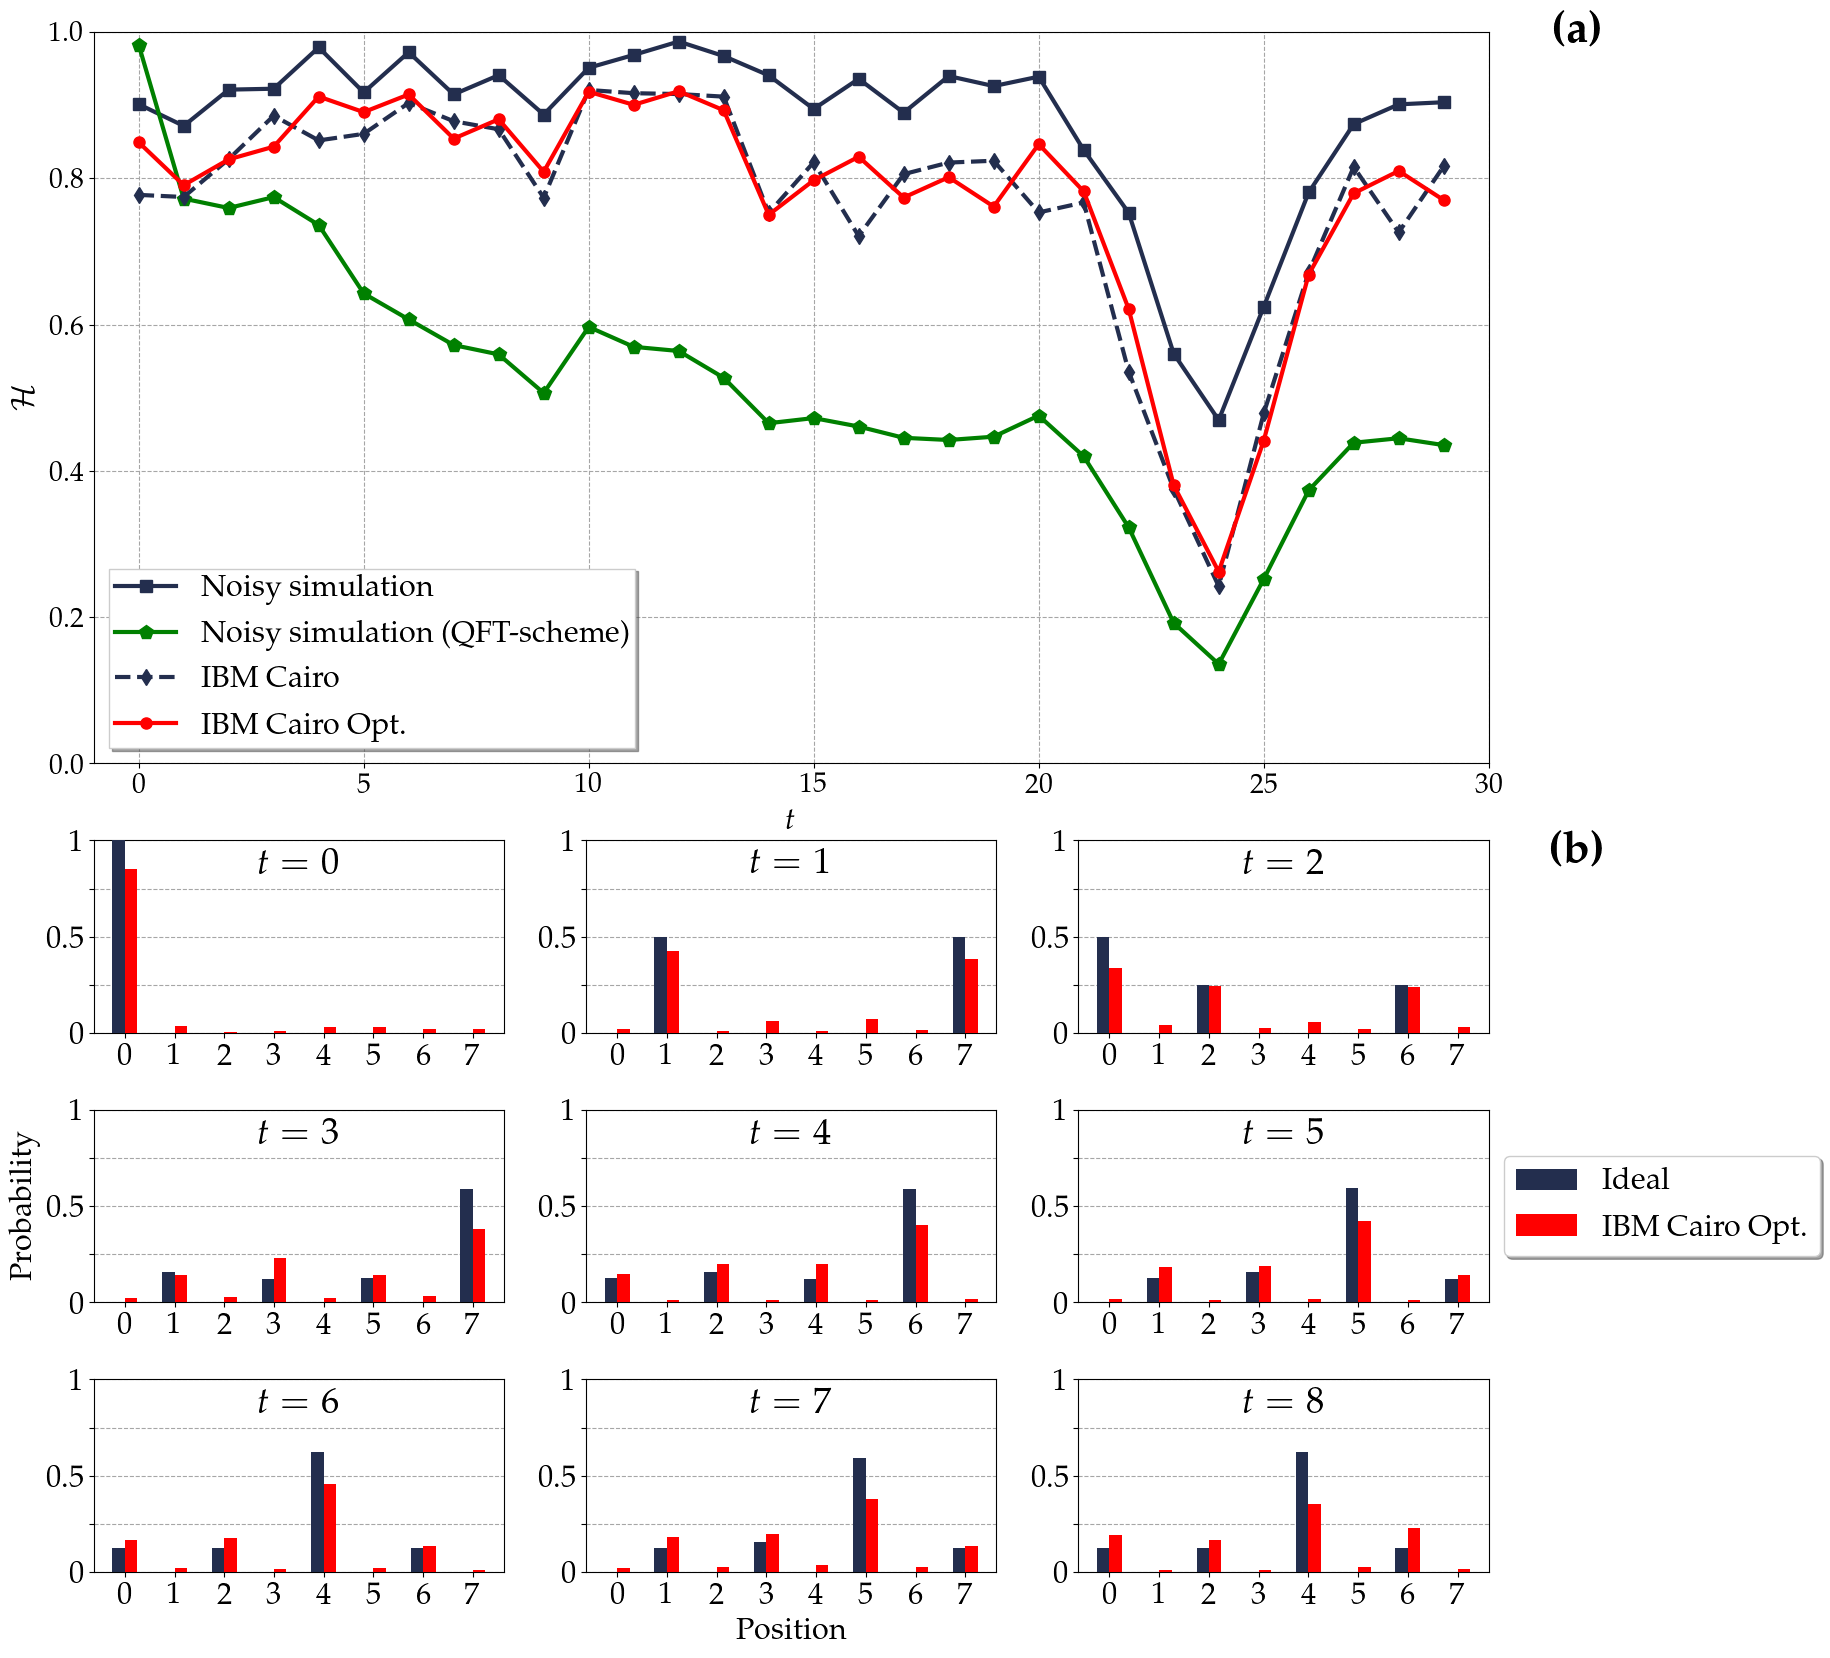

In [165]:
fig=plt.figure(figsize=[18,20])

plots = []
titles=['$t=0$','$t=1$','$t=2$','$t=3$','$t=4$','$t=5$','$t=6$','$t=7$','$t=8$']

ax = plt.subplot2grid((6,3), (0,0),rowspan=3, colspan=3)

plt.rcParams["font.size"] = 22

ax.set_ylim([0,1])
ax.set_xlim([-1,30])
ax.plot(range(0,30),FidelityNoisy,'-s',color='#232E4E',linewidth=3,label='Noisy simulation',markersize=8)
ax.plot(range(0,30),FidelityNoisyShak,'-p',color='g',linewidth=3,label='Noisy simulation (QFT-scheme)',markersize=10)
ax.plot(range(0,30),FidelityReal,'--d',color='#232E4E',linewidth=3,label='IBM Cairo',markersize=8)
ax.plot(range(0,30),FidelityRealOpt,'r-o',linewidth=3,label='IBM Cairo Opt.',markersize=8)

ax.grid(True, which='both',ls='--',color='0.65')
ax.tick_params(axis='both',labelsize=20)

ax.legend(borderpad=0.2,fancybox=False,shadow=True)
ax.set_ylabel('$\mathcal{H}$')
ax.set_xlabel('$t$')
ax.set_xticks([0,5,10,15,20,25,30])
plt.subplots_adjust(hspace=0.4)
for i in range(3): 
    for j in range(3):
     
        countsIdeal={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0}
        countsIdeal.update(CountsIdeal3[i*3+j])
        countsNoisy={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0}
        countsNoisy.update(CountsNoisy3[i*3+j])
        countsNoisyShak={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0}
        countsNoisyShak.update(CountsNoisyShakeel3[i*3+j])
        countsReal={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0}
        countsReal.update(CountsReal3[i*3+j])
        countsRealOpt={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0}
        countsRealOpt.update(CountsRealOpt3[i*3+j])
        countsRealCorr={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0}
        countsRealCorr.update(CountsRealOptCorr3[i*3+j])

       
        width=0.25
    
        ax = plt.subplot2grid((6,3), (3+i,j))
        ax.grid(True, axis='y',ls='--',color='0.65')
        ax.bar(np.array([1,2,3,4,5,6,7,8])-width/2, countsIdeal.values(),width=width,color='#232E4E',label='Ideal',zorder=3)
        #ax.bar(np.array([1,2,3,4]), countsReal.values(),width=width,color='b')
        ax.bar(np.array([1,2,3,4,5,6,7,8])+width/2, countsRealCorr.values(),width=width,color='r',label='IBM Cairo Opt.',zorder=3)
        ax.set_ylim(0,1)
        
        ax.set_xticks([1,2,3,4,5,6,7,8])
        ax.set_xticklabels(['0','1','2','3','4','5','6','7'])

        if i*3+j==3:
            ax.set_ylabel('Probability')
        if i*3+j==7:
            ax.set_xlabel('Position')

        
        ax.set_title(titles[i*3+j],y=1, pad=-24)
       
        ax.set_yticks([0,0.25,0.5,0.75,1])
        ax.set_yticklabels(['0','','0.5','','1'])

ax.legend(loc='center left', bbox_to_anchor=(1, 1.9),ncol=1, fancybox=True, shadow=True)
#fig.text(0.5, 0.04, 'Position', va='center', ha='center')
#fig.text(0.08, 0.5, 'Probability', va='center', ha='center', rotation='vertical')

fig.text(0.95, 0.88, '\\textbf{(a)}', va='center', ha='center',fontsize=32)
fig.text(0.95, 0.47, '\\textbf{(b)}', va='center', ha='center',fontsize=32)
plt.savefig('DTQW_n3.svg',format='svg',dpi=1200, bbox_inches = 'tight')


plt.show()

### Entanglement (JANUARY 2024)

In [10]:
options = Options()
options.execution.shots = 100000
options.optimization_level = 1
options.resilience_level=0


samplerCairo = Sampler(backend=backend,options=options)

In [13]:
CoinInit=QuantumCircuit(1,name='Coin Initial')
CoinInit.u(np.pi/6,np.pi/2,0,[0])

CoinToss=QuantumCircuit(1,name='Coin Toss')
CoinToss.u(np.pi/2,2*np.pi,np.pi,[0]) # hadamard coin

Nqubit=2
T=15
Nmeas=300
N=100000
backend = provider.get_backend('ibm_cairo')
layout=[3,8,5] #physical qubits mapping

t=14
#for t in range(5,T):
qcList=[]
for n in range(Nmeas):
    qc=quantumWalkQFT(Nqubit,t,CoinInit, CoinToss,measureAll=True)
    qc.barrier()
    qc=randomMeasAll(qc,Nqubit)
    qcList.append(qc)

qcListTranspiled = transpile(qcList,backend=device,optimization_level=1,initial_layout=layout)
job=samplerCairo.run(qcListTranspiled)
    #result=job.result()
    #counts=result.quasi_dists
    #countsTIME.append(counts)

In [14]:
jobIDs=['cpe0g8h2zy6g008p3k50','cpe5qj6yx18g008bhtyg','cpe8akjprheg008s0r60','cpeb5f5mbjng00864880','cpemh14yx18g008bk390','cpf4twb2zy6g008p6kbg','cpft7gpja3gg00816he0','cpgfnbxja3gg0081801g','cpentktbtqp0008fzr2g','cphcx54mbjng0080hz80','cpf4wc1yx18g008bmbag','cpktvzf6q5h0008bmxj0','cpenvddyx18g008bk5yg','cpkzsq6sypyg008fcxmg','cpmfvxqd7p3000860pwg']


In [55]:
RESULTS=[]

In [113]:
job=service.job(jobIDs[14])

In [115]:
result=job.result()

In [116]:
RESULTS.append(result)

In [121]:
Nmeas=300
Nqubit=2
T=15
shots=100000
RErealCoin=[]
RErealWalker=[]
RErealAll=[]

meas=[0,1,2,3,4,5,6,7]

for result in RESULTS:
  
    counts=result.quasi_dists
    pCoin=np.zeros((2,Nmeas))
    pAll=np.zeros((2**(Nqubit+1),Nmeas))
    pWalker=np.zeros((2**(Nqubit),Nmeas))

    for n in range(Nmeas):
        count=counts[n]
       
        for k in range(2**Nqubit):
            pWalker[k,n]=count.get(meas[k],0) + count.get(meas[k+4],0)
        for k in range(2**(Nqubit+1)):
            pAll[k,n]=count.get(meas[k],0)
        for k in range(2):
            pCoin[k,n]=count.get(meas[k],0) +count.get(meas[k+1],0) +count.get(meas[k+2],0) +count.get(meas[k+3],0)
        
    RErealCoin.append(randomMeasEntropy(pCoin,1,Nmeas))
    RErealWalker.append(randomMeasEntropy(pWalker,Nqubit,Nmeas))
    RErealAll.append(randomMeasEntropy(pAll,Nqubit+1,Nmeas))

In [ ]:
#Renyi entropy of the state, the coin and the walker, PAREC actual hardware
T=15

#plt.axhline(y=3, color='r', linestyle='-',linewidth=2,label='Target')
#plt.axhline(y=2, color='g', linestyle='-',linewidth=2,label='Target')
#plt.axhline(y=1, color='b', linestyle='-',linewidth=2,label='Target')

plt.figure(figsize=[18,10])
plt.rcParams["font.size"] = 22
#plt.subplot(121)
#plt.ylim([-0.005,0.55])
#plt.xlim([-10,10])

plt.plot(range(0,T),np.real(RErealAll),'-s',color='#232E4E',linewidth=3,label='Total state',markersize=8)
plt.plot(range(0,T),np.real(RErealCoin),'g-d',linewidth=3,label='Coin state',markersize=8)
plt.plot(range(0,T),np.real(RErealWalker),'r-o',linewidth=3,label='Position state',markersize=8)

#plt.plot(range(0,T),np.real(RE),'r--o',linewidth=1.6,label=' Theoretical Walker Entropy',)



plt.grid(True, which='both',ls='--',color='0.65')
plt.tick_params(axis='both',labelsize=20)

plt.legend(fontsize=16, borderpad=0.2,fancybox=False,shadow=True)
plt.ylabel('Rényi Entropy')
plt.xlabel('$t$')
plt.xticks([0,2,4,6,8,10,12,14])

plt.savefig('DTQW_n2_Entropies_GENNAIO.svg',format='svg',dpi=1200, bbox_inches = 'tight')

plt.show()


## Circuits transpiled

In [ ]:
CoinInit=QuantumCircuit(1,name='Coin Initial')
CoinInit.u(np.pi/6,np.pi/2,0,[0])

CoinToss=QuantumCircuit(1,name='Coin Toss')
CoinToss.u(np.pi/2,2*np.pi,np.pi,[0]) # hadamard coin

Nqubit=2
T=10

N=100000
from qiskit.providers.fake_provider import FakeCairo
backend = FakeCairo()
layout=[3,8,5] #physical qubits mapping


qcList=[]
for t in range(11):
    qc=quantumWalkQFT(Nqubit,t,CoinInit, CoinToss,measureAll=True)
    qcList.append(qc)

qcListTranspiled2noOpt = transpile(qcList,backend=backend,optimization_level=1,initial_layout=layout)
qcListTranspiled2Opt = transpile(qcList,backend=backend,optimization_level=3,initial_layout=layout)


Nqubit=3
T=10

N=100000


layout=[10,13,15,12]
qcList=[]
for t in range(11):
    qc=quantumWalkQFT(Nqubit,t,CoinInit, CoinToss,measureAll=True)
    qcList.append(qc)

qcListTranspiled3noOpt = transpile(qcList,backend=backend,optimization_level=1,initial_layout=layout)
qcListTranspiled3Opt = transpile(qcList,backend=backend,optimization_level=3,initial_layout=layout)

In [299]:
def count_gates(qc: QuantumCircuit):
    gate_count ={qubit:0 for qubit in qc.qubits}
    for gate in qc.data:
        for qubit in gate.qubits:
            gate_count[qubit]+=1
    return gate_count
def remove_unused_wires(qc: QuantumCircuit):
    gate_count=count_gates(qc)
    for qubit, count in gate_count.items():
        if count==0:
            qc.qubits.remove(qubit)
    return qc



In [ ]:
qc=remove_unused_wires(qcListTranspiled2noOpt[1])
qc.barrier()
qc.measure(qubit=range(3),cbit=range(3))

qc.draw('mpl',fold=22).savefig('transpiled_circuit_n2.svg',format='svg',dpi=1200, bbox_inches = 'tight')


In [129]:
qcListTranspiled3Opt[9].num_nonlocal_gates()
qcListTranspiled3Opt[9].size()

126

In [131]:
qcListTranspiled3Opt[9].count_ops()


OrderedDict([('rz', 56), ('cx', 37), ('sx', 29), ('x', 4)])

In [141]:
sQ2noOpt=[]
tQ2noOpt=[]
depth2noOpt=[]
for cirq in qcListTranspiled2noOpt:
    sQ2noOpt.append(cirq.size()-cirq.num_nonlocal_gates())
    tQ2noOpt.append(cirq.num_nonlocal_gates())
    depth2noOpt.append(cirq.depth())

sQ2Opt=[]
tQ2Opt=[]
depth2Opt=[]
for cirq in qcListTranspiled2Opt:
    sQ2Opt.append(cirq.size()-cirq.num_nonlocal_gates())
    tQ2Opt.append(cirq.num_nonlocal_gates())
    depth2Opt.append(cirq.depth())

sQ3noOpt=[]
tQ3noOpt=[]
depth3noOpt=[]
for cirq in qcListTranspiled3noOpt:
    sQ3noOpt.append(cirq.size()-cirq.num_nonlocal_gates())
    tQ3noOpt.append(cirq.num_nonlocal_gates())
    depth3noOpt.append(cirq.depth())

sQ3Opt=[]
tQ3Opt=[]
depth3Opt=[]
for cirq in qcListTranspiled3Opt:
    sQ3Opt.append(cirq.size()-cirq.num_nonlocal_gates())
    tQ3Opt.append(cirq.num_nonlocal_gates())
    depth3Opt.append(cirq.depth())


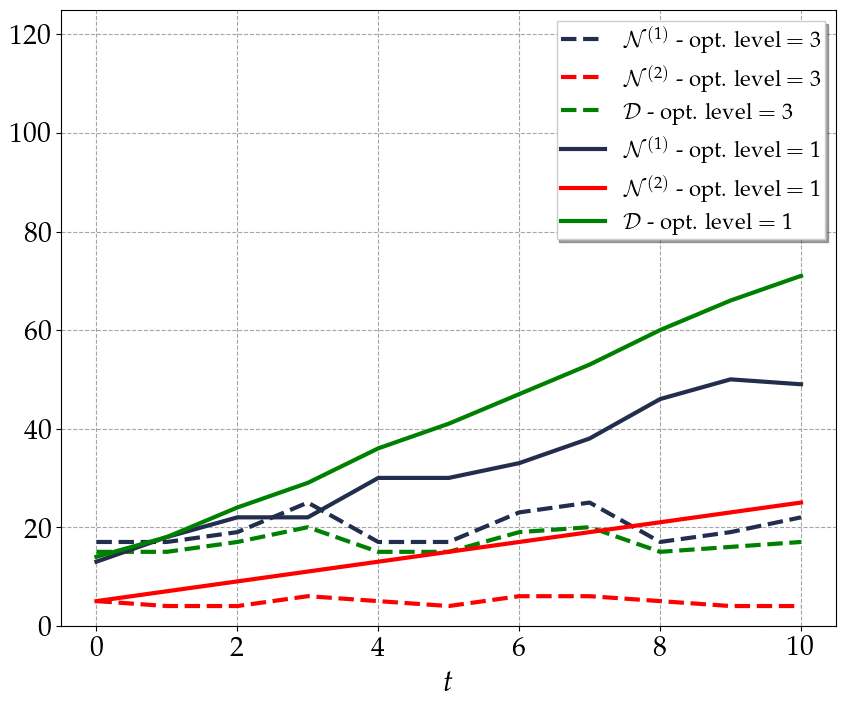

In [146]:


T=11
plt.figure(figsize=[10,8])
plt.rcParams["font.size"] = 22
#plt.subplot(121)
plt.ylim([0,125])
#plt.xlim([-10,10])

plt.plot(range(0,T),sQ2Opt,'--',color='#232E4E',linewidth=3,label='$\mathcal{N}^{(1)}$ - opt. level $=3$')
plt.plot(range(0,T),tQ2Opt,'r--',linewidth=3,label='$\mathcal{N}^{(2)}$ - opt. level $=3$')
plt.plot(range(0,T),depth2Opt,'g--',linewidth=3,label='$\mathcal{D}$ - opt. level $=3$')

plt.plot(range(0,T),sQ2noOpt,'-',color='#232E4E',linewidth=3,label='$\mathcal{N}^{(1)}$ - opt. level $=1$')
plt.plot(range(0,T),tQ2noOpt,'r-',linewidth=3,label='$\mathcal{N}^{(2)}$ - opt. level $=1$')
plt.plot(range(0,T),depth2noOpt,'g-',linewidth=3,label='$\mathcal{D}$ - opt. level $=1$')




plt.grid(True, which='both',ls='--',color='0.65')
plt.tick_params(axis='both',labelsize=20)

plt.legend(fontsize=16, borderpad=0.2,fancybox=False,shadow=True)
#plt.ylabel('$N$')
plt.xlabel('$t$')
plt.xticks([0,2,4,6,8,10])

plt.savefig('gateCount_n2.svg',format='svg',dpi=1200, bbox_inches = 'tight')

plt.show()

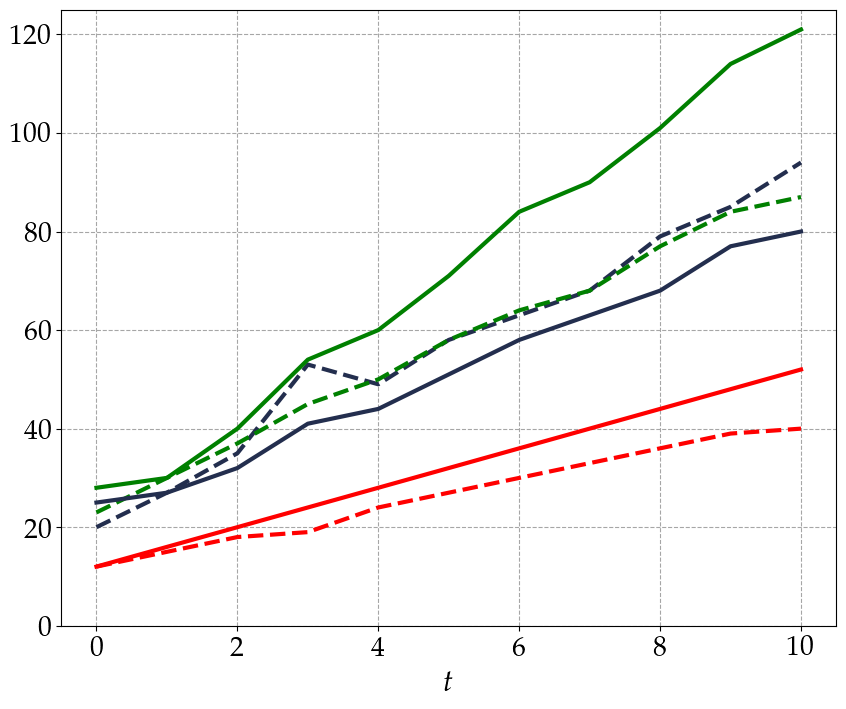

In [147]:


T=11
plt.figure(figsize=[10,8])
plt.rcParams["font.size"] = 22
#plt.subplot(121)
plt.ylim([0,125])
#plt.xlim([-10,10])

plt.plot(range(0,T),sQ3Opt,'--',color='#232E4E',linewidth=3,label='$\mathcal{N}^{(1)}$ - opt. level $=3$')
plt.plot(range(0,T),tQ3Opt,'r--',linewidth=3,label='2Q - opt. level $=3$')
plt.plot(range(0,T),depth3Opt,'g--',linewidth=3,label='Depth - opt. level $=3$')

plt.plot(range(0,T),sQ3noOpt,'-',color='#232E4E',linewidth=3,label='1Q - opt. level $=1$')
plt.plot(range(0,T),tQ3noOpt,'r-',linewidth=3,label='2Q - opt. level=1')
plt.plot(range(0,T),depth3noOpt,'g-',linewidth=3,label='Depth - opt. level=1')




plt.grid(True, which='both',ls='--',color='0.65')
plt.tick_params(axis='both',labelsize=20)

#plt.legend(fontsize=16, borderpad=0.2,fancybox=False,shadow=True)
#plt.ylabel('$N$')
plt.xlabel('$t$')
plt.xticks([0,2,4,6,8,10])
plt.savefig('gateCount_n3.svg',format='svg',dpi=1200, bbox_inches = 'tight')
#plt.savefig('DTQW_n2_Entropies_GENNAIO.svg',format='svg',dpi=1200, bbox_inches = 'tight')

plt.show()
